**Named Entity Recognition model using RNN and Simple LSTM**

In [1]:
! pip install kaggle

In [2]:
! mkdir -p ~/.kaggle
! cp /content/drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:

!kaggle datasets download naseralqaydeh/named-entity-recognition-ner-corpus

Dataset URL: https://www.kaggle.com/datasets/naseralqaydeh/named-entity-recognition-ner-corpus
License(s): DbCL-1.0
named-entity-recognition-ner-corpus.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
! unzip '/content/named-entity-recognition-ner-corpus.zip'

Archive:  /content/named-entity-recognition-ner-corpus.zip
  inflating: ner.csv                 


**Import libraries**

In [5]:
import pandas as pd
import numpy as np
import ast
import nltk
import gensim
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)


In [6]:
# loading a dataset
def loading_data(data_path):
    data = pd.read_csv(data_path)
    data.dropna(inplace=True)
    print("No of rows:", data.shape[0], "and No of columns:", data.shape[1])

    return data


In [7]:
data = loading_data('/content/ner.csv')

data.head()

No of rows: 47959 and No of columns: 4


,Sentence #,Sentence,POS,Tag
0,Sentence: 1,Thousands of demonstrators have marched throug...,"['NNS', 'IN', 'NNS', 'VBP', 'VBN', 'IN', 'NNP'...","['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', '..."
1,Sentence: 2,Families of soldiers killed in the conflict jo...,"['NNS', 'IN', 'NNS', 'VBN', 'IN', 'DT', 'NN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
2,Sentence: 3,They marched from the Houses of Parliament to ...,"['PRP', 'VBD', 'IN', 'DT', 'NNS', 'IN', 'NN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
3,Sentence: 4,"Police put the number of marchers at 10,000 wh...","['NNS', 'VBD', 'DT', 'NN', 'IN', 'NNS', 'IN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
4,Sentence: 5,The protest comes on the eve of the annual con...,"['DT', 'NN', 'VBZ', 'IN', 'DT', 'NN', 'IN', 'D...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."


In [8]:
print(data['Sentence #'][7])
print(data['Sentence'][7])
print((data['POS'])[7])
print((data['Tag'])[7])

Sentence: 8
The International Atomic Energy Agency is to hold second day of talks in Vienna Wednesday on how to respond to Iran 's resumption of low-level uranium conversion .
['DT', 'NNP', 'NNP', 'NNP', 'NNP', 'VBZ', 'TO', 'VB', 'JJ', 'NN', 'IN', 'NNS', 'IN', 'NNP', 'NNP', 'IN', 'WRB', 'TO', 'VB', 'TO', 'NNP', 'POS', 'NN', 'IN', 'JJ', 'NN', 'NN', '.']
['O', 'B-org', 'I-org', 'I-org', 'I-org', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'B-tim', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


**Convert POS and Tag Columns to Lists: These are currently stored as strings and need to be converted back to lists.**

In [9]:
data['POS'] = data['POS'].apply(ast.literal_eval)
data['Tag'] = data['Tag'].apply(ast.literal_eval)



In [10]:
data.head()

,Sentence #,Sentence,POS,Tag
0,Sentence: 1,Thousands of demonstrators have marched throug...,"[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo..."
1,Sentence: 2,Families of soldiers killed in the conflict jo...,"[NNS, IN, NNS, VBN, IN, DT, NN, VBD, DT, NNS, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,Sentence: 3,They marched from the Houses of Parliament to ...,"[PRP, VBD, IN, DT, NNS, IN, NN, TO, DT, NN, IN...","[O, O, O, O, O, O, O, O, O, O, O, B-geo, I-geo..."
3,Sentence: 4,"Police put the number of marchers at 10,000 wh...","[NNS, VBD, DT, NN, IN, NNS, IN, CD, IN, NNS, V...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
4,Sentence: 5,The protest comes on the eve of the annual con...,"[DT, NN, VBZ, IN, DT, NN, IN, DT, JJ, NN, IN, ...","[O, O, O, O, O, O, O, O, O, O, O, B-geo, O, O,..."


**Tokenize Sentences**

In [11]:
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [12]:
# Tokenizing Sentences
data['Tokenized_Words'] = data['Sentence'].apply(word_tokenize)

# Display first few rows to verify tokenization
print(data[['Sentence', 'Tokenized_Words']].head())

                                            Sentence  \
0  Thousands of demonstrators have marched throug...   
1  Families of soldiers killed in the conflict jo...   
2  They marched from the Houses of Parliament to ...   
3  Police put the number of marchers at 10,000 wh...   
4  The protest comes on the eve of the annual con...   

                                     Tokenized_Words  
0  [Thousands, of, demonstrators, have, marched, ...  
1  [Families, of, soldiers, killed, in, the, conf...  
2  [They, marched, from, the, Houses, of, Parliam...  
3  [Police, put, the, number, of, marchers, at, 1...  
4  [The, protest, comes, on, the, eve, of, the, a...  


**Map Tags to Integers**

To map Named Entity Recognition (NER) tags to numerical labels, follow these steps:


1.   Extract unique tags from the dataset.
2.   Create a mapping dictionary to assign each tag a unique integer.
3.   Convert the 'Tag' column from text-based NER labels to integer values.





In [13]:
# Extract all unique NER tags
unique_tags = set(tag for tags in data['Tag'] for tag in tags)

# Create a mapping from tags to integers
tag2idx = {tag: idx for idx, tag in enumerate(unique_tags)}

# Apply mapping to convert tags to integers
data['Tag_Numeric'] = data['Tag'].apply(lambda tags: [tag2idx[tag] for tag in tags])

In [14]:
# Display first few rows to verify mapping
print("NER Tag Mapping:", tag2idx)
print(data[['Tag', 'Tag_Numeric']].head())

NER Tag Mapping: {'B-nat': 0, 'O': 1, 'B-tim': 2, 'I-gpe': 3, 'I-nat': 4, 'I-org': 5, 'I-art': 6, 'I-eve': 7, 'B-org': 8, 'I-per': 9, 'B-gpe': 10, 'B-art': 11, 'I-geo': 12, 'B-geo': 13, 'B-eve': 14, 'I-tim': 15, 'B-per': 16}
                                                 Tag  \
0  [O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...   
1  [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...   
2  [O, O, O, O, O, O, O, O, O, O, O, B-geo, I-geo...   
3      [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]   
4  [O, O, O, O, O, O, O, O, O, O, O, B-geo, O, O,...   

                                         Tag_Numeric  
0  [1, 1, 1, 1, 1, 1, 13, 1, 1, 1, 1, 1, 13, 1, 1...  
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
2       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 13, 12, 1]  
3      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]  
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 13, 1, 1, 8,...  


**Word Embeddings Using Word2Vec**

run the word2vec and check for accuracy and then come back right here to check out (glove model)

In [15]:
import gensim
from gensim.models import Word2Vec

In [16]:
# Prepare tokenized sentences for Word2Vec
sentences = data['Tokenized_Words'].tolist()

In [17]:
# Train Word2Vec model
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)



In [18]:
# Convert words to embeddings
def word_to_embedding(sentence):
    return [word2vec_model.wv[word] if word in word2vec_model.wv else [0] * 100 for word in sentence]

# Apply embedding conversion to dataset
data['Word_Embeddings'] = data['Tokenized_Words'].apply(word_to_embedding)



In [19]:
# Display first few rows to verify
print(data[['Tokenized_Words', 'Word_Embeddings']].head())


                                     Tokenized_Words  \
0  [Thousands, of, demonstrators, have, marched, ...   
1  [Families, of, soldiers, killed, in, the, conf...   
2  [They, marched, from, the, Houses, of, Parliam...   
3  [Police, put, the, number, of, marchers, at, 1...   
4  [The, protest, comes, on, the, eve, of, the, a...   

                                     Word_Embeddings  
0  [[0.06281017, 0.8027359, 0.16512945, 0.6051087...  
1  [[-0.041443303, 0.021483047, -0.0008960101, 0....  
2  [[-0.63319004, -0.59213066, -0.7450351, 1.2023...  
3  [[0.046972547, 0.109179005, -1.3335519, 0.7858...  
4  [[-0.68427473, -0.25421154, 0.85454196, 0.5886...  


**Padding Sentences**







In [20]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Determine the maximum sentence length
max_length = max(data['Tokenized_Words'].apply(len))
embedding_dim = 100  # Same as Word2Vec vector size

# Pad Word Embeddings
def pad_word_embeddings(embeddings):
    return pad_sequences(embeddings, maxlen=max_length, dtype='float32', padding='post', truncating='post', value=0.0)

# Pad Tag Sequences
def pad_tag_sequences(tags):
    return pad_sequences(tags, maxlen=max_length, padding='post', truncating='post', value=0)

In [21]:
# Apply Padding
data['Padded_Embeddings'] = list(pad_word_embeddings(data['Word_Embeddings']))
data['Padded_Tags'] = list(pad_tag_sequences(data['Tag_Numeric']))

In [22]:
# Prepare data for training
X = np.array(data['Padded_Embeddings'].tolist())
y = np.array(data['Padded_Tags'].tolist())
y = tf.keras.utils.to_categorical(y, num_classes=len(tag2idx))

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [23]:
# Display padded results
print("Max Sentence Length:", max_length)
print(data[['Tokenized_Words', 'Padded_Embeddings', 'Padded_Tags']].head())

Max Sentence Length: 104
                                     Tokenized_Words  \
0  [Thousands, of, demonstrators, have, marched, ...   
1  [Families, of, soldiers, killed, in, the, conf...   
2  [They, marched, from, the, Houses, of, Parliam...   
3  [Police, put, the, number, of, marchers, at, 1...   
4  [The, protest, comes, on, the, eve, of, the, a...   

                                   Padded_Embeddings  \
0  [[0.06281017, 0.8027359, 0.16512945, 0.6051087...   
1  [[-0.041443303, 0.021483047, -0.0008960101, 0....   
2  [[-0.63319004, -0.59213066, -0.7450351, 1.2023...   
3  [[0.046972547, 0.109179005, -1.3335519, 0.7858...   
4  [[-0.68427473, -0.25421154, 0.85454196, 0.5886...   

                                         Padded_Tags  
0  [1, 1, 1, 1, 1, 1, 13, 1, 1, 1, 1, 1, 13, 1, 1...  
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 13, 12, 1, 0...  
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
4  [1, 1, 1, 1, 1, 1, 1, 1

In [24]:
# Prepare data for training
X = np.array(data['Padded_Embeddings'].tolist())
y = np.array(data['Padded_Tags'].tolist())
y = tf.keras.utils.to_categorical(y, num_classes=len(tag2idx))

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

-----------------------------------------------------------------------------------------------------------------

**Model Architectures**

In [25]:
def create_simple_rnn_model():
    model = Sequential([
        tf.keras.layers.InputLayer(input_shape=(max_length, embedding_dim)),
        tf.keras.layers.SimpleRNN(128, return_sequences=True),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(len(tag2idx), activation='softmax')
    ])
    return model

In [39]:
def create_lstm_model():
    model = Sequential([
        tf.keras.layers.InputLayer(input_shape=(max_length, embedding_dim)),
        LSTM(128, return_sequences=True),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(len(tag2idx), activation='softmax')
    ])
    return model

In [31]:
# Training Function
def train_model(model, model_name):
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )

    checkpoint = ModelCheckpoint(
        f'best_{model_name}.h5',
        monitor='val_accuracy',
        save_best_only=True
    )

    history = model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping, checkpoint]
    )

    return history

In [27]:
# Plot Training History
def plot_training_history(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history['accuracy'], label='Training')
    ax1.plot(history.history['val_accuracy'], label='Validation')
    ax1.set_title(f'{model_name} - Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    ax2.plot(history.history['loss'], label='Training')
    ax2.plot(history.history['val_loss'], label='Validation')
    ax2.set_title(f'{model_name} - Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()

In [32]:
# Plotting Function
def plot_training_history(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history['accuracy'], label='Training')
    ax1.plot(history.history['val_accuracy'], label='Validation')
    ax1.set_title(f'{model_name} - Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    ax2.plot(history.history['loss'], label='Training')
    ax2.plot(history.history['val_loss'], label='Validation')
    ax2.set_title(f'{model_name} - Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()

In [33]:
# Evaluation Function
def evaluate_model(model, model_name):
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"\n{model_name} Test Accuracy: {test_accuracy:.4f}")

    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=-1)
    y_true = np.argmax(y_test, axis=-1)

    idx2tag = {idx: tag for tag, idx in tag2idx.items()}
    y_pred_tags = [[idx2tag[idx] for idx in sequence] for sequence in y_pred]
    y_true_tags = [[idx2tag[idx] for idx in sequence] for sequence in y_true]

    y_pred_flat = [item for sublist in y_pred_tags for item in sublist]
    y_true_flat = [item for sublist in y_true_tags for item in sublist]

    print("\nClassification Report:")
    print(classification_report(y_true_flat, y_pred_flat))

    f1 = f1_score(y_true_flat, y_pred_flat, average='weighted')
    print(f"Weighted F1 Score: {f1:.4f}")

In [34]:
# Prediction Function
def predict_entities(model, sentence):
    tokens = word_tokenize(sentence)
    embeddings = word_to_embedding(tokens)
    padded_sequence = pad_word_embeddings([embeddings])
    predictions = model.predict(padded_sequence)
    predicted_tags = np.argmax(predictions[0], axis=-1)

    idx2tag = {idx: tag for tag, idx in tag2idx.items()}
    predicted_entities = [idx2tag[idx] for idx in predicted_tags[:len(tokens)]]

    entities = []
    for token, tag in zip(tokens, predicted_entities):
        if tag != 'O':
            entities.append((token, tag))

    return entities

In [35]:
# Train and evaluate a specific model
def run_model(model_name, model_function):
    print(f"\nTraining {model_name}...")
    model = model_function()
    history = train_model(model, model_name.lower().replace(' ', '_'))
    plot_training_history(history, model_name)
    evaluate_model(model, model_name)
    return model


Training Simple RNN...
Epoch 1/10
960/960 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9463 - loss: 0.2326

960/960 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.9463 - loss: 0.2325 - val_accuracy: 0.9836 - val_loss: 0.0601
Epoch 2/10
959/960 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9820 - loss: 0.0672

960/960 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9820 - loss: 0.0672 - val_accuracy: 0.9854 - val_loss: 0.0519
Epoch 3/10
956/960 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9836 - loss: 0.0590

960/960 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9836 - loss: 0.0590 - val_accuracy: 0.9863 - val_loss: 0.0479
Epoch 4/10
958/960 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9846 - loss: 0.0548

960/960 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9846 - loss: 0.0548 - val_accuracy: 0.9869 - val_loss: 0.0453
Epoch 5/10
956/960 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9853 - loss: 0.0519

960/960 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9853 - loss: 0.0519 - val_accuracy: 0.9873 - val_loss: 0.0434
Epoch 6/10
959/960 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9856 - loss: 0.0501

960/960 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.9856 - loss: 0.0501 - val_accuracy: 0.9876 - val_loss: 0.0421
Epoch 7/10
959/960 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9861 - loss: 0.0485

960/960 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9861 - loss: 0.0485 - val_accuracy: 0.9877 - val_loss: 0.0411
Epoch 8/10
955/960 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9864 - loss: 0.0472

960/960 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9864 - loss: 0.0472 - val_accuracy: 0.9880 - val_loss: 0.0401
Epoch 9/10
957/960 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9865 - loss: 0.0462

960/960 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.9865 - loss: 0.0462 - val_accuracy: 0.9881 - val_loss: 0.0395
Epoch 10/10
959/960 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9867 - loss: 0.0452

960/960 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9867 - loss: 0.0452 - val_accuracy: 0.9882 - val_loss: 0.0393


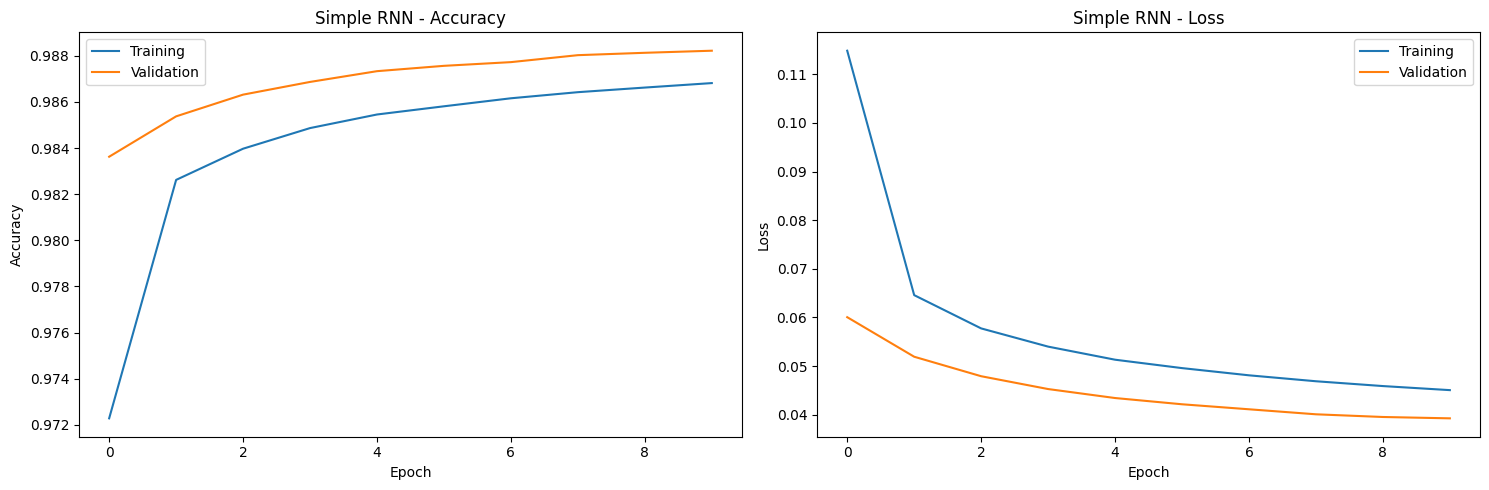

300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9877 - loss: 0.0406

Simple RNN Test Accuracy: 0.9881
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step

Classification Report:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        86
       B-eve       0.73      0.13      0.23        60
       B-geo       0.79      0.81      0.80      7664
       B-gpe       0.92      0.78      0.84      3175
       B-nat       1.00      1.00      1.00    788683
       B-org       0.76      0.36      0.49      3913
       B-per       0.82      0.63      0.71      3389
       B-tim       0.93      0.71      0.80      4049
       I-art       0.00      0.00      0.00        58
       I-eve       0.07      0.02      0.03        53
       I-geo       0.79      0.61      0.69      1450
       I-gpe       1.00      0.10      0.19        39
       I-nat       0.00      0.00      0.00        12
       I-org       0.75      0.58      0.65      3315
       I-per       0.75      0.91      0.82      3445
       I-tim       0.79      0.57      0.66      1300
           O       0.96      0.99      0.98    176877

    accuracy              

In [36]:
simple_rnn_model = run_model('Simple RNN', create_simple_rnn_model)


Training LSTM...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/10
957/960 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9561 - loss: 0.2891

960/960 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.9562 - loss: 0.2884 - val_accuracy: 0.9858 - val_loss: 0.0515
Epoch 2/10
960/960 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9846 - loss: 0.0562

960/960 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9846 - loss: 0.0562 - val_accuracy: 0.9873 - val_loss: 0.0442
Epoch 3/10
957/960 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9861 - loss: 0.0490

960/960 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9861 - loss: 0.0490 - val_accuracy: 0.9880 - val_loss: 0.0407
Epoch 4/10
959/960 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9868 - loss: 0.0455

960/960 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9868 - loss: 0.0455 - val_accuracy: 0.9885 - val_loss: 0.0385
Epoch 5/10
957/960 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9874 - loss: 0.0430

960/960 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.9874 - loss: 0.0430 - val_accuracy: 0.9888 - val_loss: 0.0372
Epoch 6/10
957/960 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9878 - loss: 0.0412

960/960 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.9878 - loss: 0.0412 - val_accuracy: 0.9891 - val_loss: 0.0361
Epoch 7/10
960/960 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9882 - loss: 0.0397

960/960 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9882 - loss: 0.0397 - val_accuracy: 0.9892 - val_loss: 0.0353
Epoch 8/10
959/960 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9885 - loss: 0.0386

960/960 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.9885 - loss: 0.0386 - val_accuracy: 0.9894 - val_loss: 0.0346
Epoch 9/10
957/960 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9887 - loss: 0.0375

960/960 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.9887 - loss: 0.0375 - val_accuracy: 0.9895 - val_loss: 0.0341
Epoch 10/10
960/960 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.9889 - loss: 0.0366 - val_accuracy: 0.9895 - val_loss: 0.0338


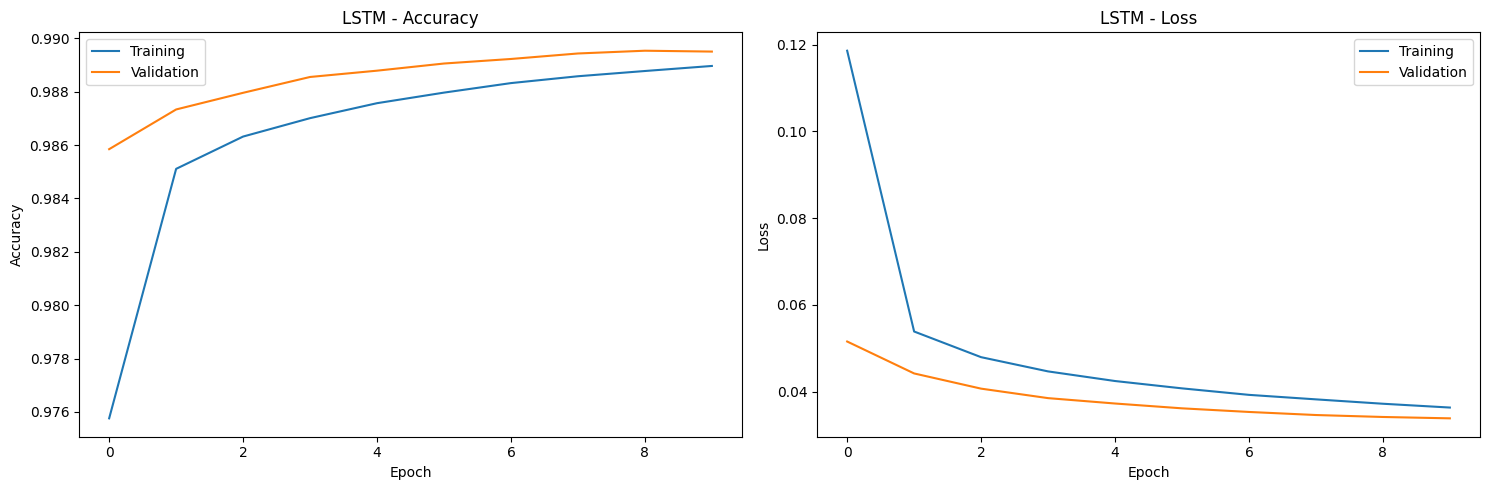

300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9892 - loss: 0.0353

LSTM Test Accuracy: 0.9894
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

Classification Report:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        86
       B-eve       0.45      0.17      0.24        60
       B-geo       0.81      0.83      0.82      7664
       B-gpe       0.92      0.83      0.87      3175
       B-nat       1.00      1.00      1.00    788683
       B-org       0.77      0.41      0.54      3913
       B-per       0.79      0.68      0.73      3389
       B-tim       0.90      0.78      0.84      4049
       I-art       0.00      0.00      0.00        58
       I-eve       0.26      0.09      0.14        53
       I-geo       0.80      0.68      0.73      1450
       I-gpe       0.00      0.00      0.00        39
       I-nat       0.00      0.00      0.00        12
       I-org       0.78      0.64      0.70      3315
       I-per       0.76      0.92      0.83      3445
       I-tim       0.75      0.66      0.70      1300
           O       0.97      0.99      0.98    176877

    accuracy              

In [40]:
lstm_model = run_model('LSTM', create_lstm_model)

In [43]:
# Example prediction
test_sentence = "Apple Inc. CEO Tim Cook announced new iPhone in California."
best_model = lstm_model  # Change this to simple_rnn_model if you want to use the RNN model
entities = predict_entities(best_model, test_sentence)
print("\nPredicted entities:", entities)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step

Predicted entities: [('Apple', 'B-per'), ('CEO', 'I-per'), ('Tim', 'I-per'), ('California', 'B-geo')]


In [44]:
test_sentence = "Elon Musk founded SpaceX in 2002 and Tesla in 2003."
best_model = lstm_model  # or simple_rnn_model
entities = predict_entities(best_model, test_sentence)
print("\nPredicted entities:", entities)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Predicted entities: [('Musk', 'I-per'), ('SpaceX', 'I-per'), ('2002', 'B-tim'), ('and', 'I-tim'), ('Tesla', 'I-tim'), ('2003', 'B-tim')]
